[*********************100%%**********************]  1 of 1 completed


Epoch 1/25
132/132 [==============================] - 31s 196ms/step - loss: 0.0185
Epoch 2/25
132/132 [==============================] - 26s 194ms/step - loss: 0.0060
Epoch 3/25
132/132 [==============================] - 26s 194ms/step - loss: 0.0051
Epoch 4/25
132/132 [==============================] - 25s 193ms/step - loss: 0.0050
Epoch 5/25
132/132 [==============================] - 25s 191ms/step - loss: 0.0044
Epoch 6/25
132/132 [==============================] - 25s 192ms/step - loss: 0.0036
Epoch 7/25
132/132 [==============================] - 25s 191ms/step - loss: 0.0040
Epoch 8/25
132/132 [==============================] - 25s 193ms/step - loss: 0.0033
Epoch 9/25
132/132 [==============================] - 25s 192ms/step - loss: 0.0031
Epoch 10/25
132/132 [==============================] - 25s 191ms/step - loss: 0.0031
Epoch 11/25
132/132 [==============================] - 25s 190ms/step - loss: 0.0030
Epoch 12/25
132/132 [==============================] - 25s 190ms/step - lo

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


15/15 [==============================] - 2s 100ms/step


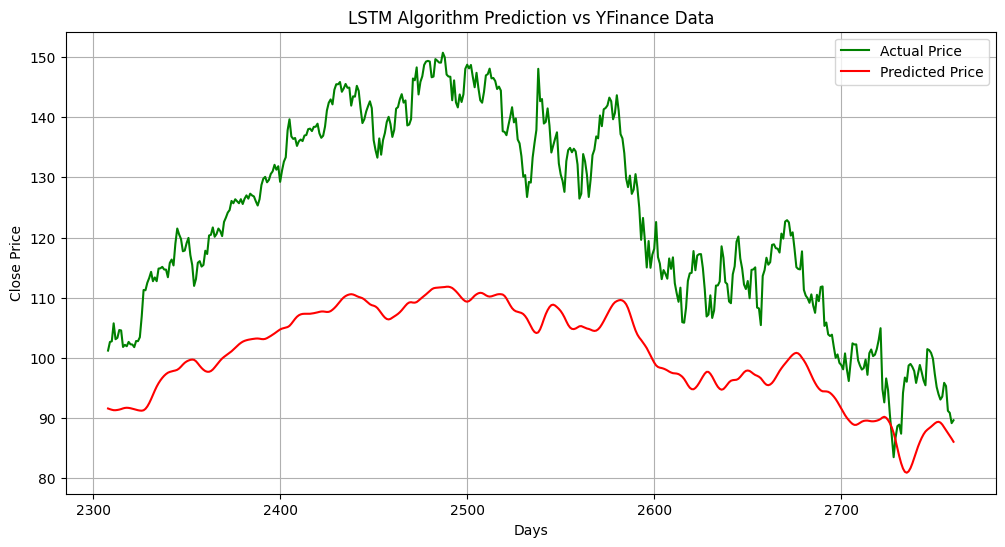

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# Define the start and end dates, and the stock symbol
start = '2012-01-01'
end = '2022-12-21'
stock = 'GOOG'

# Download and preprocess the data
data = yf.download(stock, start, end)
data.reset_index(inplace=True)

# Calculate the 100 and 200-day moving averages
ma_100_days = data.Close.rolling(100).mean()
ma_200_days = data.Close.rolling(200).mean()

data.dropna(inplace=True)
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

# Scale the training data
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

# Prepare the training input and output
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

x, y = np.array(x), np.array(y)

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x, y, epochs=25, batch_size=16, verbose=1)

# Prepare and scale the test data
test_data = data_test.values
test_data = scaler.transform(test_data)

x_test = []

for i in range(100, test_data.shape[0]):
    x_test.append(test_data[i-100:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict the test data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot the comparison graph with improved clarity
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(predictions):], data_test.values[-len(predictions):], 'g', label='Actual Price')
plt.plot(data.index[-len(predictions):], predictions, 'r', label='Predicted Price')
plt.title('LSTM Algorithm Prediction vs YFinance Data')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
